In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from util import *
import os
from count_FM_function_v3 import *
from DirichletFM_function import *
from models import * 
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

# 1. Generate Data

In [2]:
np.random.seed(0)
N = 1000

# target
k    = np.array([[60.0, 5.0],  [60.0, 40.0]])   # shapes for comp 0 and 1 (2 dims)
rate = np.array([[1.0, 1.0],  [1.0, 1.0]])   # rates  for comp 0 and 1 (2 dims)
z = (np.random.rand(N) < 0.5).astype(int)    # 50/50 mixture labels
lam1 = np.random.gamma(shape=k[z], scale=1.0/rate[z])  # λ ~ 0.5*Gamma0 + 0.5*Gamma1
X1 = np.random.poisson(lam1)

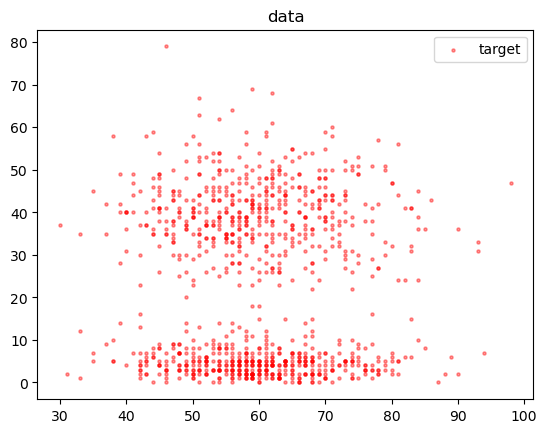

In [3]:
alpha_pt = 0.4
plt.scatter(X1[:,0], X1[:,1], c = 'r', s = 5, alpha = alpha_pt, label = 'target');
plt.title('data');
plt.legend();

# 2. Preperation

## 2.1 count FM

In [4]:
eps_t = 1e-4 # add some eps to avoid rate blow up for t = 1
eps_log = 1e-8 # for Poisson deviance...
lr = 1e-3
X1_torch = torch.tensor(X1)
N, d = X1_torch.shape

In [5]:
separate_heads = False
if not separate_heads:
    net_base = MLP(dim=d, out_dim=2*d, w=64, time_varying=True).to(device)
    net = MLP_rate(net_base)
    params = list(net.parameters())
    nets_countFM = net
    
if separate_heads:
    net_base_b = MLP(dim=d, out_dim=d, w=64, time_varying=True).to(device)  # births
    net_base_d = MLP(dim=d, out_dim=d, w=64, time_varying=True).to(device)  # deaths
    net_b = MLP_rate(net_base_b)
    net_d = MLP_rate(net_base_d)
    params = list(net_b.parameters()) + list(net_d.parameters())
    nets_countFM = [net_b, net_d]
    
opt_countFM = torch.optim.Adam(params, lr=lr)

## 2.2 Dirichlet FM

In [70]:
train_counts, C_max = build_count_dataset(X1, C_max=None, margin=2)
train_counts = train_counts.to(device)

# alpha_min, alpha_max, alpha_scale = suggest_alpha_hyper(C_max)
alpha_min, alpha_max, alpha_scale = 1.0, 100.0, 20.0 # defaul values in their code
print(alpha_min, alpha_max, alpha_scale)

1.0 100.0 20.0


In [71]:
condflow_counts = DirichletConditionalFlow(
    K=C_max + 1,
    alpha_min=alpha_min,
    alpha_max=alpha_max,
    alpha_spacing=0.01,   # same as repo
)

In [72]:
N, D = train_counts.shape
K = C_max + 1
classifier_DirFM = DirichletFMClassifier(num_dims=D, K=K, mlp_width=64, time_varying=True).to(device)
opt_DirFM = torch.optim.Adam(classifier_DirFM.parameters(), lr=lr)

# 3. Train

In [13]:
batch_size = 256
num_epochs = 10000

## 3.1 Count FM

In [11]:
loss_mode = 'poisson' # or 'poisson'/ 'l2'

In [14]:
nets_countFM, loss_countFM = CountFM_train(X1_torch, nets_countFM, opt_countFM, num_epochs, batch_size, device, separate_heads=separate_heads,
                                           x0_mode="uniform",  # "uniform", "poisson", or "dataset"
                                           C_max=C_max,
                                           eps_t=eps_t, eps_log=eps_log, loss_mode=loss_mode,
                                          )

  0%|                                                 | 0/10000 [00:00<?, ?it/s]/home/ganchao/miniconda3/envs/vfm/lib/python3.9/site-packages/torch/utils/_device.py:103: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  return func(*args, **kwargs)
  0%|                                       | 28/10000 [00:00<01:06, 149.96it/s]

[CountFM][epoch 0] loss=-95.533478


 20%|███████▌                             | 2033/10000 [00:10<00:41, 190.45it/s]

[CountFM][epoch 2000] loss=-149.903992


 40%|██████████████▉                      | 4025/10000 [00:20<00:29, 199.78it/s]

[CountFM][epoch 4000] loss=-144.930481


 60%|██████████████████████▎              | 6025/10000 [00:30<00:19, 204.71it/s]

[CountFM][epoch 6000] loss=-143.669952


 80%|█████████████████████████████▋       | 8021/10000 [00:40<00:09, 204.12it/s]

[CountFM][epoch 8000] loss=-138.280014


100%|████████████████████████████████████| 10000/10000 [00:50<00:00, 199.38it/s]


## 3.2 Dirichlet FM

In [73]:
t_schedule = 'exp'

In [74]:
classifier_DirFM, loss_DirFM = DFM_train(train_counts, C_max, batch_size, num_epochs,
              classifier_DirFM, alpha_scale, alpha_min, alpha_max, t_schedule,
              opt_DirFM, device)

  0%|▏                                      | 46/10000 [00:00<00:43, 227.80it/s]

[DFM][epoch 0] loss=4.508536


 20%|███████▌                             | 2043/10000 [00:08<00:34, 231.78it/s]

[DFM][epoch 2000] loss=0.731541


 40%|██████████████▉                      | 4029/10000 [00:17<00:26, 223.55it/s]

[DFM][epoch 4000] loss=0.811026


 60%|██████████████████████▎              | 6030/10000 [00:26<00:16, 236.83it/s]

[DFM][epoch 6000] loss=0.699503


 80%|█████████████████████████████▋       | 8027/10000 [00:34<00:08, 237.09it/s]

[DFM][epoch 8000] loss=0.665557


100%|████████████████████████████████████| 10000/10000 [00:42<00:00, 232.64it/s]


# 4. Generation

In [21]:
np.random.seed(123)
N_new = 1000
n_step = 1000
dist0 = torch.distributions.Dirichlet(torch.ones(K, device=device))
x = dist0.rsample((N_new, D))     # [B,D,K]
x0_prob = x / x.sum(-1, keepdim=True)

x0_new = x0_prob.argmax(-1).cpu()
x0_new_torch = torch.tensor(x0_new)

/home/ganchao/miniconda3/envs/vfm/lib/python3.9/site-packages/torch/utils/_device.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


## 4.1 Binomial bridge

In [33]:
x1_countFM, traj_countFM = sample_euler(nets_countFM, n_step, x0_new_torch, device, eps_t, eps_log, separate_heads)
x1_countFM_np = x1_countFM.detach().cpu().numpy()
traj_countFM_np = traj_countFM.detach().cpu().numpy()

## 4.2 Dirichlet bridge

In [78]:
X1_DirFM, traj_DirFM = sample_dfm_counts(
    classifier=classifier_DirFM,
    condflow=condflow_counts,
    num_samples=N_new,
    D=D,
    C_max=C_max,
    num_steps=n_step,
    alpha_min=alpha_min,
    alpha_max=alpha_max,
    device=device,
    return_traj=True,
    x0 = x0_prob
)

# 5. Plot

## 5.1 Generated samples

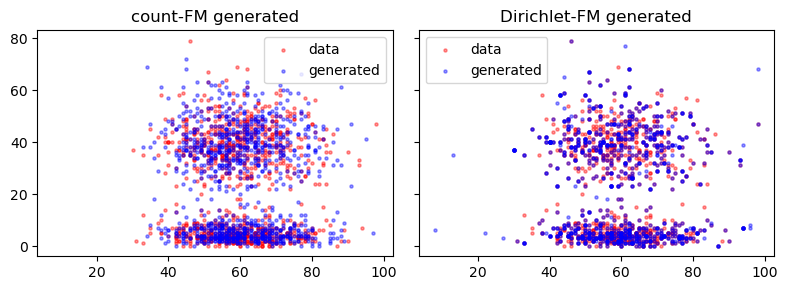

In [79]:
k = 2
fig, axes = plt.subplots(1, k, figsize=(4 * k, 3), sharex=True, sharey=True)

axes[0].scatter(X1[:,0], X1[:,1], c = 'r', s = 5, alpha = alpha_pt, label = 'data');
axes[0].scatter(x1_countFM_np[:,0], x1_countFM_np[:,1], c = 'b', s = 5, alpha = alpha_pt, label = 'generated');
axes[0].set_title('count-FM generated')
axes[0].legend(loc="best")

axes[1].scatter(X1[:,0], X1[:,1], c = 'r', s = 5, alpha = alpha_pt, label = 'data');
axes[1].scatter(X1_DirFM[:,0], X1_DirFM[:,1], c = 'b', s = 5, alpha = alpha_pt, label = 'generated');
axes[1].set_title('Dirichlet-FM generated');
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

## 5.2 Generated trajectories
Let's just show snapshots (although count-FM is easy to show the whole trajectories)...

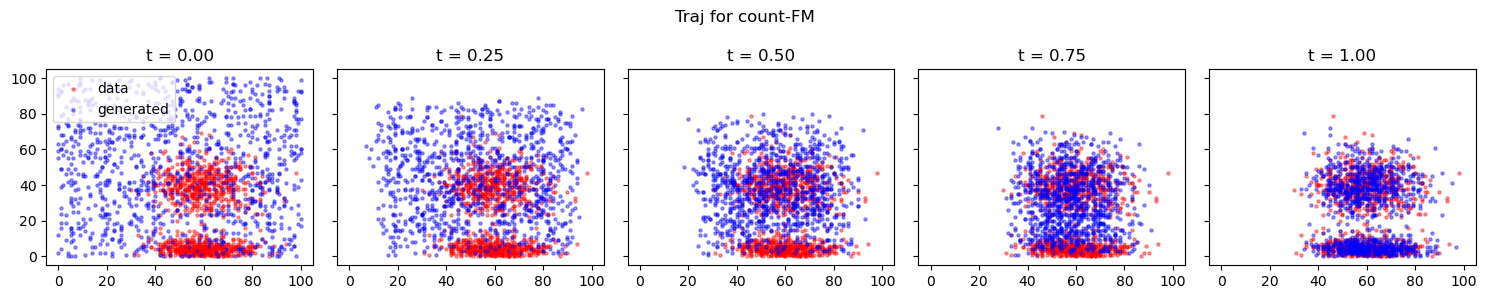

In [80]:
k = 5  # number of snapshots
T = traj_countFM_np.shape[0] - 1  # last valid time index (here 1000)
snapshot_ids = np.linspace(0, T, k, dtype=int)

fig, axes = plt.subplots(1, k, figsize=(3 * k, 3), sharex=True, sharey=True)

for j, t_idx in enumerate(snapshot_ids):
    ax = axes[j]
    ax.scatter(X1[:, 0], X1[:, 1], c='r', s=5, alpha=alpha_pt, label='data')
    ax.scatter(traj_countFM_np[t_idx, :, 0],
               traj_countFM_np[t_idx, :, 1],
               c='b', s=5, alpha=alpha_pt, label='generated')
    t_normalized = t_idx / T  # in [0, 1]
    ax.set_title(f"t = {t_normalized:.2f}")

    if j == 0:
        ax.legend(loc="best")

plt.suptitle('Traj for count-FM')
plt.tight_layout()
plt.show()

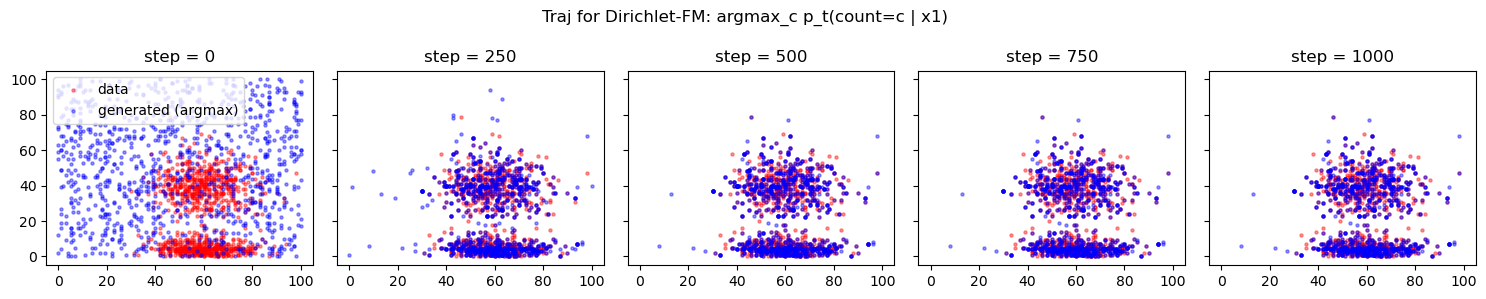

In [81]:
traj_DirFM_np = traj_DirFM.cpu().numpy()
traj_DirFM_counts_np = traj_DirFM_np.argmax(axis=-1)   # [T+1, B, D]

k = 5  # number of snapshots
T = traj_DirFM_counts_np.shape[0] - 1  # last valid time index
snapshot_ids = np.linspace(0, T, k, dtype=int)

fig, axes = plt.subplots(1, k, figsize=(3 * k, 3), sharex=True, sharey=True)

for j, t_idx in enumerate(snapshot_ids):
    ax = axes[j]
    ax.scatter(X1[:, 0], X1[:, 1],
               c='r', s=5, alpha=alpha_pt, label='data')
    ax.scatter(traj_DirFM_counts_np[t_idx, :, 0],
               traj_DirFM_counts_np[t_idx, :, 1],
               c='b', s=5, alpha=alpha_pt, label='generated (argmax)')
    ax.set_title(f"step = {t_idx}")

    if j == 0:
        ax.legend(loc="best")

plt.suptitle("Traj for Dirichlet-FM: argmax_c p_t(count=c | x1)")
plt.tight_layout()
plt.show()